# Benchmark XGBoost explanations

This notebook compares several different explantion methods when applied to XGBoost models. These methods are compared across many different evaluation metrics. Explanation error is the primary metric we sort by, but we also compare across many other metrics, since no single metric fully captures the performance of an attribution explanation method.

For a more detailed explanation of each of the metrics used here please check out the documation strings of the various classes.

## Benchmark explainers on an XGBoost regression model of Boston housing

### Build the model and explanations

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import shap
import shap.benchmark
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import warnings
import xgboost

warnings.filterwarnings("ignore")

In [ ]:
model = GradientBoostingRegressor(subsample=0.3)
X, y = shap.datasets.california(n_points=1000)
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model.fit(
    X_train,
    y_train,
    # eval_set=[(X_test, y_test)],
    # early_stopping_rounds=10,
    # verbose=False,
)

# define the benchmark evaluation sample set
X_eval = X_test[:]
y_eval = y_test[:]

# use an independent masker
masker = shap.maskers.Independent(X_train)
pmasker = shap.maskers.Partition(X_train)

# build the explainers
explainers = [
    ("Permutation", shap.PermutationExplainer(model.predict, masker)),
    ("Permutation part.", shap.PermutationExplainer(model.predict, pmasker)),
    ("Partition", shap.PartitionExplainer(model.predict, pmasker)),
    ("Tree", shap.TreeExplainer(model)),
    ("Tree approx.", shap.TreeExplainer(model, approximate=True)),
    ("Exact", shap.ExactExplainer(model.predict, masker)),
    ("Random", shap.explainers.other.Random(model.predict, masker)),
]

# # dry run to get all the code warmed up for valid runtime measurements
for name, exp in explainers:
    exp(X_eval[:1])

# explain with all the explainers
attributions = [(name, exp(X_eval)) for name, exp in explainers]

### Run the benchmarks

In [2]:
results = {}

smasker = shap.benchmark.ExplanationError(masker, model.predict, X_eval)
results["explanation error"] = [smasker(v, name=n) for n, v in attributions]

ct = shap.benchmark.ComputeTime()
results["compute time"] = [ct(v, name=n) for n, v in attributions]

for mask_type, ordering in [
    ("keep", "positive"),
    ("remove", "positive"),
    ("keep", "negative"),
    ("remove", "negative"),
]:
    smasker = shap.benchmark.SequentialMasker(
        mask_type, ordering, masker, model.predict, X_eval
    )
    results[mask_type + " " + ordering] = [smasker(v, name=n) for n, v in attributions]

cmasker = shap.maskers.Composite(masker, shap.maskers.Fixed())
for mask_type, ordering in [("keep", "absolute"), ("remove", "absolute")]:
    smasker = shap.benchmark.SequentialMasker(
        mask_type,
        ordering,
        cmasker,
        lambda X, y: (y - model.predict(X)) ** 2,
        X_eval,
        y_eval,
    )
    results[mask_type + " " + ordering] = [smasker(v, name=n) for n, v in attributions]

### Show scores across all metrics for all explainers

This multi-metric benchmark plot sorts the method by the first method, and rescales the scores to be relative for each metric, so that the best score appears at the top and the worse score at the bottom.

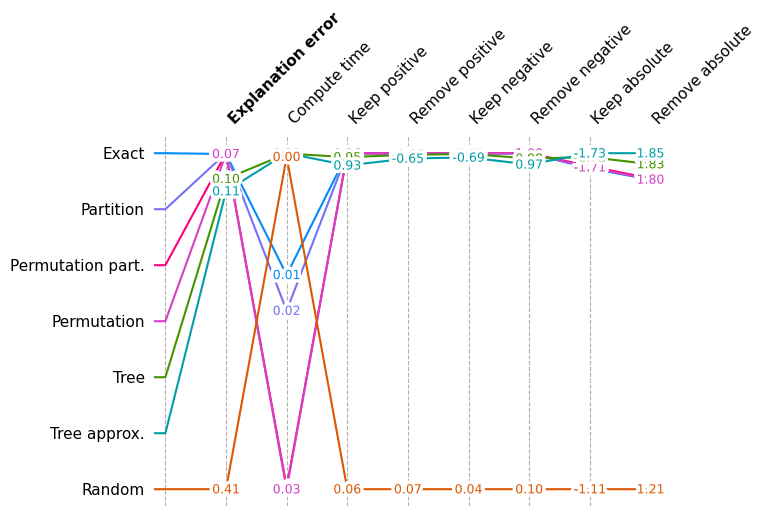

In [3]:
shap.plots.benchmark(sum(results.values(), []))

#### Show overall performance again but without Random

Since random scores are so much worse than reasonable explanation methods, we draw the same plot again but without the Random method so we can see smaller variations in performance.

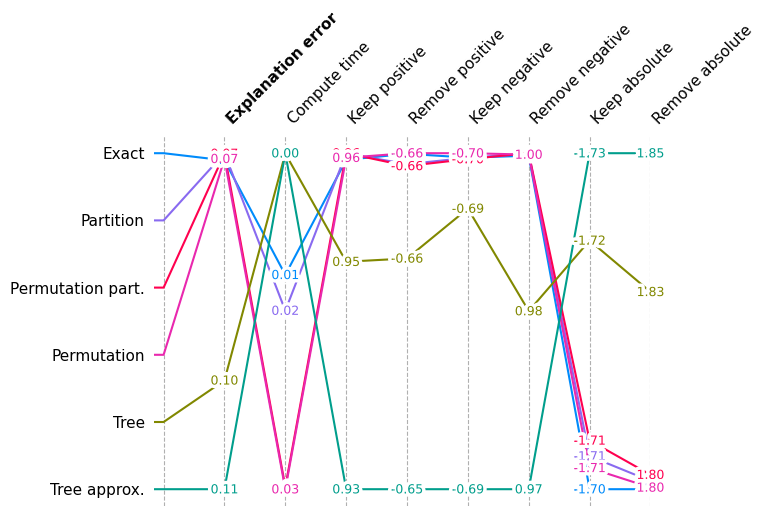

In [4]:
shap.plots.benchmark(filter(lambda x: x.method != "Random", sum(results.values(), [])))

### Show detail plots of each metric type

If we plot scores for one metric at a time then we can see a much more detailed comparison of the methods. Some methods just have a score (explanation error and compute time) while other methods have entire performance curves, and the score is the area under (or over) these curves.

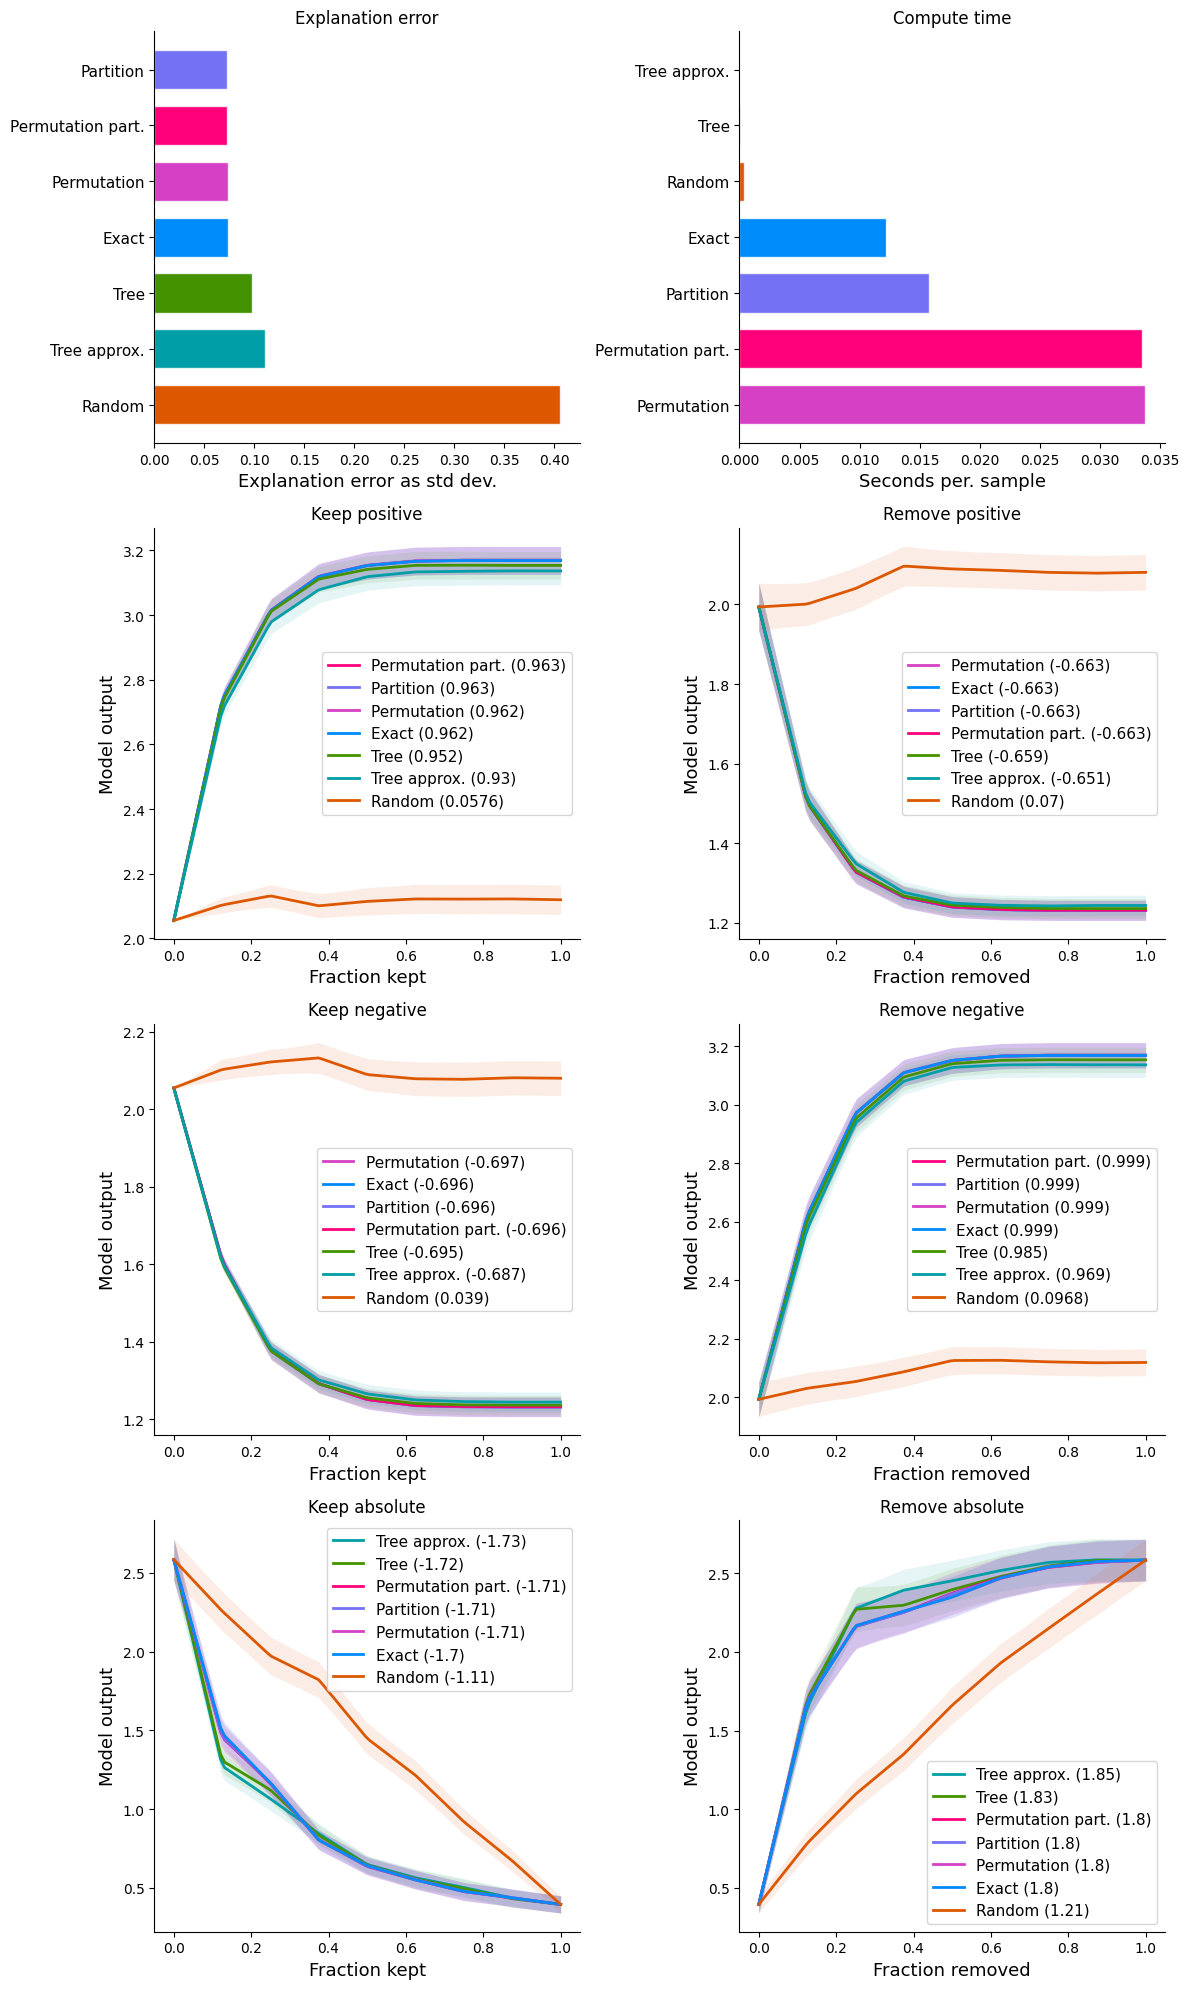

In [5]:
num_plot_rows = len(results) // 2 + len(results) % 2
fig, ax = plt.subplots(num_plot_rows, 2, figsize=(12, 5 * num_plot_rows))

for i, k in enumerate(results):
    plt.subplot(num_plot_rows, 2, i + 1)
    shap.plots.benchmark(results[k], show=False)
if i % 2 == 0:
    ax[-1, -1].axis("off")
plt.tight_layout()
plt.show()

## Benchmark explainers on an XGBoost classification model of census reported income

### Build the model and explanations

In [6]:
# build the model
model = xgboost.XGBClassifier(n_estimators=1000, subsample=0.3)
X, y = shap.datasets.adult(n_points=1000)
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=False,
)


def logit_predict(X):
    return model.predict(X, output_margin=True)


def loss_predict(X, y):
    probs = model.predict_proba(X)
    return [-np.log(probs[i, y[i] * 1]) for i in range(len(y))]


# define the benchmark evaluation sample set (limited to 1000 samples for the sake of time)
X_eval = X_test[:1000]
y_eval = y_test[:1000]

# use an independent masker
masker = shap.maskers.Independent(X_train)
pmasker = shap.maskers.Partition(X_train)

# build the explainers
explainers = [
    ("Permutation", shap.PermutationExplainer(logit_predict, masker)),
    ("Permutation part.", shap.PermutationExplainer(logit_predict, pmasker)),
    ("Partition", shap.PartitionExplainer(logit_predict, pmasker)),
    ("Tree", shap.TreeExplainer(model)),
    ("Tree approx.", shap.TreeExplainer(model, approximate=True)),
    ("Random", shap.explainers.other.Random(logit_predict, masker)),
    ("Exact", shap.ExactExplainer(logit_predict, masker)),
]

# # dry run to get all the code warmed up for valid runtime measurements
for name, exp in explainers:
    exp(X_eval[:1])

# explain with all the explainers
attributions = [(name, exp(X_eval)) for name, exp in explainers]

PartitionExplainer explainer: 251it [00:29,  5.62it/s]                         


### Run the benchmarks

In [7]:
results = {}

# we run explanation error first as the primary metric
smasker = shap.benchmark.ExplanationError(masker, logit_predict, X_eval)
results["explanation error"] = [smasker(v, name=n) for n, v in attributions]

# next compute time
ct = shap.benchmark.ComputeTime()
results["compute time"] = [ct(v, name=n) for n, v in attributions]

# then removal and addition of feature metrics based on model output
for mask_type, ordering in [
    ("keep", "positive"),
    ("remove", "positive"),
    ("keep", "negative"),
    ("remove", "negative"),
]:
    smasker = shap.benchmark.SequentialMasker(
        mask_type, ordering, masker, logit_predict, X_eval
    )
    results[mask_type + " " + ordering] = [smasker(v, name=n) for n, v in attributions]

# then removal and addition of feature metrics based on model loss
cmasker = shap.maskers.Composite(masker, shap.maskers.Fixed())
for mask_type, ordering in [("keep", "absolute"), ("remove", "absolute")]:
    smasker = shap.benchmark.SequentialMasker(
        mask_type, ordering, cmasker, loss_predict, X_eval, y_eval
    )
    results[mask_type + " " + ordering] = [smasker(v, name=n) for n, v in attributions]

### Show an overall area-under-curve score across all metrics for all explainers

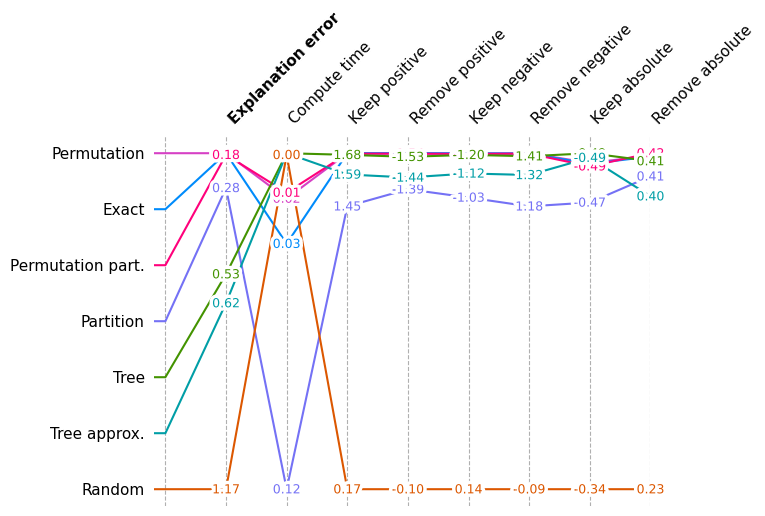

In [8]:
shap.plots.benchmark(sum(results.values(), []))

#### Show overall performance again but without Random

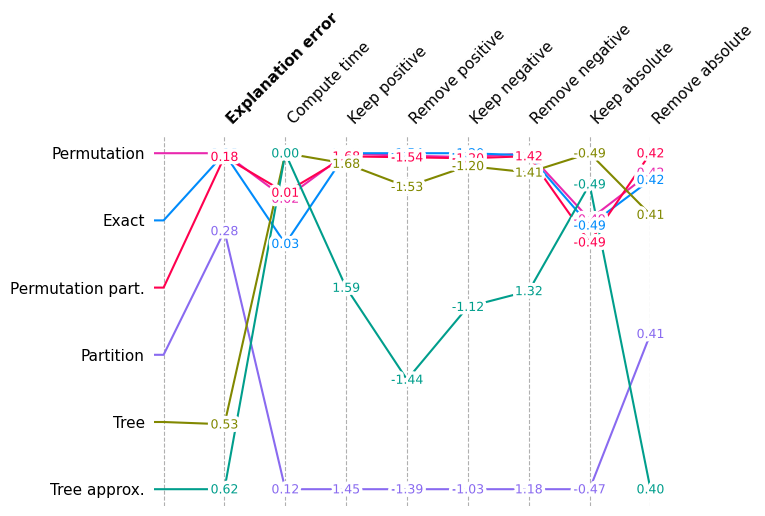

In [9]:
shap.plots.benchmark(filter(lambda x: x.method != "Random", sum(results.values(), [])))

### Show detail plots of each metric type

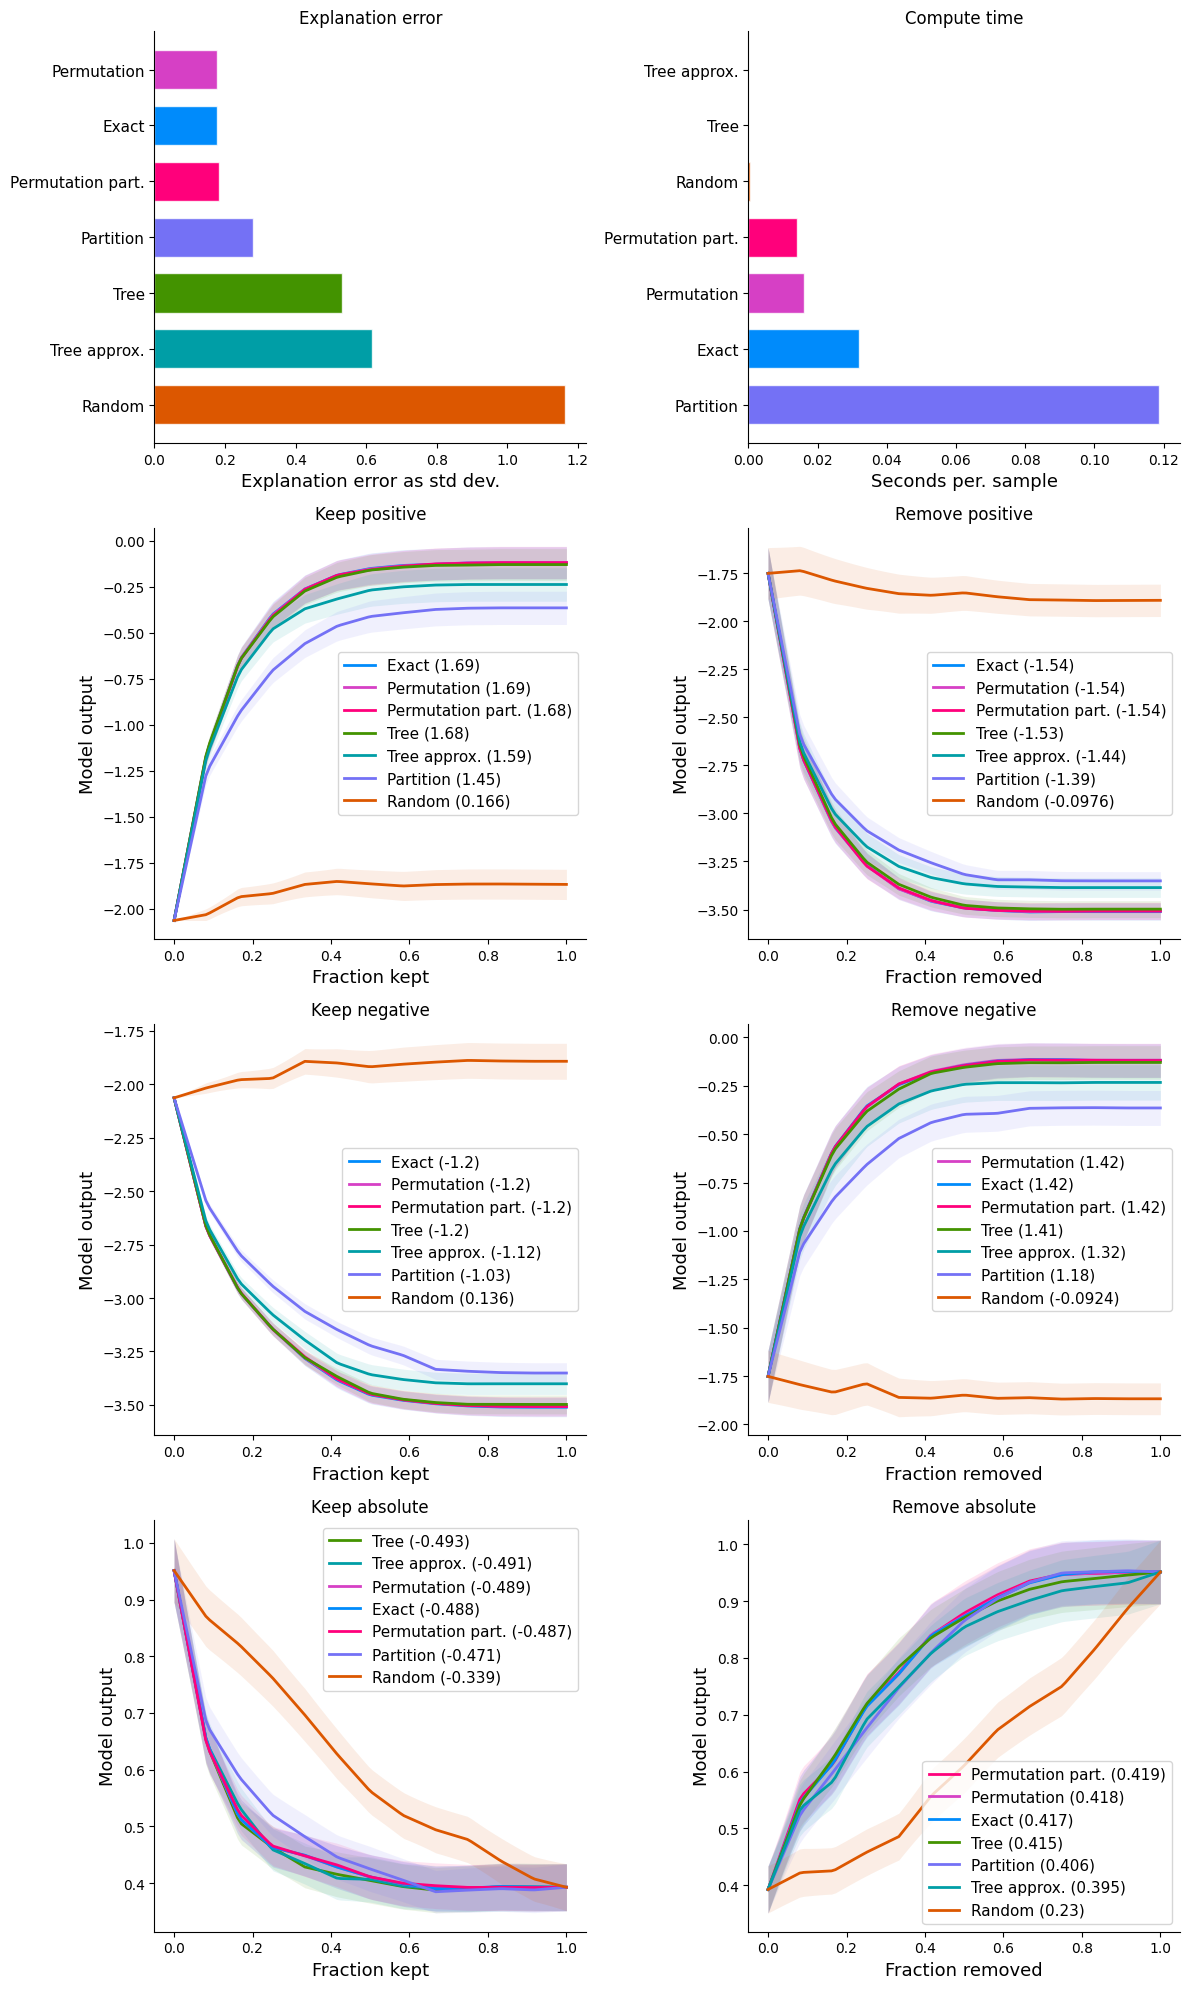

In [10]:
num_plot_rows = len(results) // 2 + len(results) % 2
fig, ax = plt.subplots(num_plot_rows, 2, figsize=(12, 5 * num_plot_rows))

for i, k in enumerate(results):
    plt.subplot(num_plot_rows, 2, i + 1)
    shap.plots.benchmark(results[k], show=False)
if i % 2 == 0:
    ax[-1, -1].axis("off")
plt.tight_layout()
plt.show()

<hr>
Have an idea for more helpful examples? Pull requests that add to this documentation notebook are encouraged! 